<a href="https://colab.research.google.com/github/ziatdinovmax/Notebooks-for-papers/blob/master/Si_in_graphene_atomai_v2a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Analysis of impurity motion in graphene

**Notebook prepared by Maxim Ziatdinov**

Contact e-mail: ziatdinovmax@gmail.com

This notebook shows how to apply AtomAI to analysis of local distortions in graphene with impurity/impurities.

First, install AtomAI:

In [1]:
!pip install -q atomai==0.3.5

     |████████████████████████████████| 61kB 4.3MB/s 


In [2]:
#@title Imports { form-width: "20%" }
# Imports
import numpy as np
import matplotlib.pyplot as plt
import atomai as aoi

import warnings
warnings.filterwarnings("ignore", module="atomai.core.atomnet")

In [3]:
#@title Download experimental data and model weights
!gdown https://drive.google.com/uc?id=1ukKpOdPp4a1U1UNkneU50gQsCKRFRFcu
!gdown https://drive.google.com/uc?id=1uqJNFIuXecN_oHw6NpsxlOZ2zC2LeCH7

Downloading...
From: https://drive.google.com/uc?id=1ukKpOdPp4a1U1UNkneU50gQsCKRFRFcu
To: /content/G-Si-DFT0-1-4-best_weights.pt
10.2MB [00:00, 47.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1uqJNFIuXecN_oHw6NpsxlOZ2zC2LeCH7
To: /content/Graphene_Si-circle.npy
27.8MB [00:00, 88.3MB/s]


In [4]:
#@title Load neural network skeleton { form-width: "20%" }
import torch
import torch.nn as nn
import torch.nn.functional as F

class conv2dblock(nn.Module):
    '''
    Creates a block consisting of convolutional
    layer, leaky relu and (optionally) dropout and
    batch normalization
    '''
    def __init__(self, input_channels, output_channels,
                 kernel_size=3, stride=1, padding=1,
                 use_batchnorm=False, lrelu_a=0.01,
                 dropout_=0):
        '''
        Args:
            input_channels: number of channels in the previous/input layer
            output_channels: number of the output channels for the present layer
            kernel_size: size (in pixels) of convolutional filter
            stride: value of convolutional filter stride
            padding: value of padding at the edges
            use_batchnorm (boolean): usage of batch normalization
            lrelu_a: value of alpha parameter in leaky/paramteric ReLU activation
            dropout_: value of dropout
        '''
        super(conv2dblock, self).__init__()
        block = []
        block.append(nn.Conv2d(input_channels,
                               output_channels,
                               kernel_size=kernel_size,
                               stride=stride,
                               padding=padding))
        if dropout_ > 0:
            block.append(nn.Dropout(dropout_))
        block.append(nn.LeakyReLU(negative_slope=lrelu_a))
        if use_batchnorm:
            block.append(nn.BatchNorm2d(output_channels))
        self.block = nn.Sequential(*block)

    def forward(self, x):
        '''Forward pass'''
        output = self.block(x)
        return output

class dilation_block(nn.Module):
    '''
    Creates a block with dilated convolutional
    layers (aka atrous convolutions)
    '''
    def __init__(self, input_channels, output_channels,
                 dilation_values, padding_values,
                 kernel_size=3, stride=1, lrelu_a=0.01,
                 use_batchnorm=False, dropout_=0):
        '''
        Args:
            input_channels: number of channels in the previous/input layer
            output_channels: number of the output channels for the present layer
            dilation_values: list of dilation rates for convolution operation
            kernel_size: size (in pixels) of convolutional filter
            stride: value of convolutional filter stride
            padding: value of padding at the edges
            use_batchnorm (boolean): usage of batch normalization
            lrelu_a: value of alpha parameter in leaky/paramteric ReLU activation
            dropout_: value of dropout
            '''
        super(dilation_block, self).__init__()
        atrous_module = []
        for idx, (dil, pad) in enumerate(zip(dilation_values, padding_values)):
            input_channels = output_channels if idx > 0 else input_channels
            atrous_module.append(nn.Conv2d(input_channels,
                                           output_channels,
                                           kernel_size=kernel_size,
                                           stride=stride,
                                           padding=pad,
                                           dilation=dil,
                                           bias=True))
            if dropout_ > 0:
                atrous_module.append(nn.Dropout(dropout_))
            atrous_module.append(nn.LeakyReLU(negative_slope=lrelu_a))
            if use_batchnorm:
                atrous_module.append(nn.BatchNorm2d(output_channels))
        self.atrous_module = nn.Sequential(*atrous_module)

    def forward(self, x):
        '''Forward pass'''
        atrous_layers = []
        for conv_layer in self.atrous_module:
            x = conv_layer(x)
            atrous_layers.append(x.unsqueeze(-1))
        return torch.sum(torch.cat(atrous_layers, dim=-1), dim=-1)

class upsample_block(nn.Module):
    '''
    Defines upsampling block performed either with
    bilinear interpolation followed by 1-by-1
    convolution or with a transposed convolution
    '''
    def __init__(self, input_channels, output_channels,
                 mode='interpolate', kernel_size=1,
                 stride=1, padding=0):
        '''
        Args:
            input_channels: number of channels in the previous/input layer
            output_channels: number of the output channels for the present layer
            mode: upsampling mode (default: 'interpolate')
            kernel_size: size (in pixels) of convolutional filter
            stride: value of convolutional filter stride
            padding: value of padding at the edges
            '''
        super(upsample_block, self).__init__()
        self.mode = mode
        self.conv = nn.Conv2d(
            input_channels, output_channels,
            kernel_size = kernel_size,
            stride = stride, padding = padding)
        self.conv_t = nn.ConvTranspose2d(
            input_channels, output_channels,
            kernel_size=2, stride=2, padding = 0)

    def forward(self, x):
        '''Defines a forward pass'''
        if self.mode == 'interpolate':
            x = F.interpolate(
                x, scale_factor=2,
                mode='bilinear', align_corners=False)
            return self.conv(x)
        return self.conv_t(x)


class atomsegnet(nn.Module):
    '''
    Builds  a fully convolutional neural network model
    '''
    def __init__(self, nb_classes=1, nb_filters=32):
        '''
        Args:
            nb_classes (int): number of classes
            nb_filters (int): number of filters in the first convolutional layer
        '''
        super(atomsegnet, self).__init__()
        self.pxac = 'sigmoid' if nb_classes < 2 else 'softmax'
        self.c1 = conv2dblock(1, nb_filters)
        
        self.c2 = nn.Sequential(conv2dblock(nb_filters,
                                            nb_filters*2),
                                conv2dblock(nb_filters*2,
                                            nb_filters*2))
        
        self.c3 = nn.Sequential(conv2dblock(nb_filters*2,
                                            nb_filters*4,
                                            dropout_=0.3),
                                conv2dblock(nb_filters*4,
                                            nb_filters*4,
                                            dropout_=0.3))
        
        self.bn = dilation_block(nb_filters*4,
                                 nb_filters*8,
                                 dilation_values=[2, 4, 6],
                                 padding_values=[2, 4, 6],
                                 dropout_=0.5)
        
        self.upsample_block1 = upsample_block(nb_filters*8,
                                              nb_filters*4)
        
        self.c4 = nn.Sequential(conv2dblock(nb_filters*8,
                                            nb_filters*4,
                                            dropout_=0.3),
                                conv2dblock(nb_filters*4,
                                            nb_filters*4,
                                            dropout_=0.3))
        
        self.upsample_block2 = upsample_block(nb_filters*4,
                                              nb_filters*2)
        
        self.c5 = nn.Sequential(conv2dblock(nb_filters*4,
                                            nb_filters*2),
                                conv2dblock(nb_filters*2,
                                            nb_filters*2))
        
        self.upsample_block3 = upsample_block(nb_filters*2,
                                              nb_filters)
        
        self.c6 = conv2dblock(nb_filters*2,
                              nb_filters)
        
        self.px = nn.Conv2d(nb_filters,
                            nb_classes,
                            kernel_size=1,
                            stride=1,
                            padding=0)
               
    def forward(self, x):
        '''Defines a forward pass'''
        # Contracting path
        c1 = self.c1(x)
        d1 = F.max_pool2d(c1, kernel_size=2, stride=2)
        c2 = self.c2(d1)
        d2 = F.max_pool2d(c2, kernel_size=2, stride=2)
        c3 = self.c3(d2)
        d3 = F.max_pool2d(c3, kernel_size=2, stride=2)
        # Atrous convolutions
        bn = self.bn(d3)
        # Expanding path
        u3 = self.upsample_block1(bn)
        u3 = torch.cat([c3, u3], dim=1)
        u3 = self.c4(u3)
        u2 = self.upsample_block2(u3)
        u2 = torch.cat([c2, u2], dim=1)
        u2 = self.c5(u2)
        u1 = self.upsample_block3(u2)
        u1 = torch.cat([c1, u1], dim=1)
        u1 = self.c6(u1)
        # pixel-wise classification
        px = self.px(u1)
        if self.pxac == 'sigmoid':
            output = torch.sigmoid(px)
        elif self.pxac == 'softmax':
            output = F.log_softmax(px, dim=1)
        return output

Load experimental data:

In [5]:
expdata = np.load('Graphene_Si-circle.npy')

Load trained weights into a model skeleton:

In [6]:
weights_path = 'G-Si-DFT0-1-4-best_weights.pt'
model = atomsegnet()
model = aoi.load_weights(model, weights_path)

We start by applying a pre-trained neural network to the experimental data. Notice that older models used in AICrystallographer had sigmoid/softmax activation as the last "layer", while AtomAI models are outputting *logits* and softmax/sigmoid operation is a part of prediction (this is a more numerically stable option). Since we are using the older model from AICrystalographer, we need to specify ```logits=False``` in our predictor.

Here we set ```refine=True```, which will perform a peak refinement with a standard 2D gaussian fitting using the neural prediction as initial guess. Notice that the refinement part is currently not GPU-accelerated and hence may take some time (several minutes).

In [7]:
nn_input, (nn_output, coordinates) = aoi.atomnet.predictor(
    model, refine=True, logits=False, use_gpu=True).run(expdata)

Batch 10/10
Refining atomic positions... Done

53 images were decoded in approximately 209.1547 seconds


Plot the results:

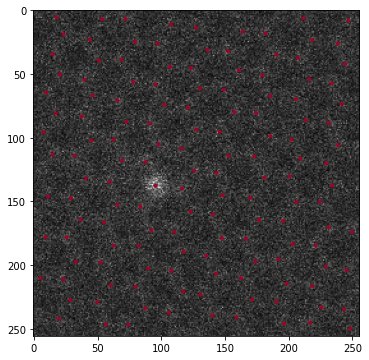

In [8]:
# Plot results
k = 4 # frame number
aoi.utils.plot_coord(expdata[k], coordinates[k])

Our model was trained to find atoms, but it doesn't distinguish between two atom types. Thankfully, AtomAI has an option for updating coordinates based on clustering analysis or a simple thresholding of intensities in the detected atomic positions.

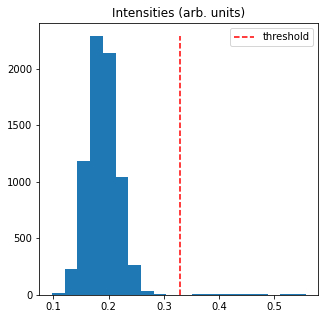

In [9]:
coordinates = aoi.atomstat.update_classes(
    coordinates, nn_input, method='threshold', thresh=.33)

Plot the updated predictions:

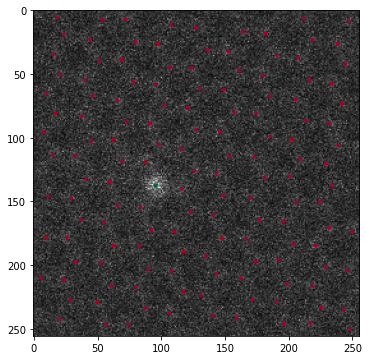

In [10]:
aoi.utils.plot_coord(expdata[k], coordinates[k])

Map all bonds:

(All the results are automatically saved to disk)

/usr/local/lib/python3.6/dist-packages/atomai/core/atomstat.py:857: UserWarning: Currently supports only square images
  warnings.warn("Currently supports only square images", UserWarning)


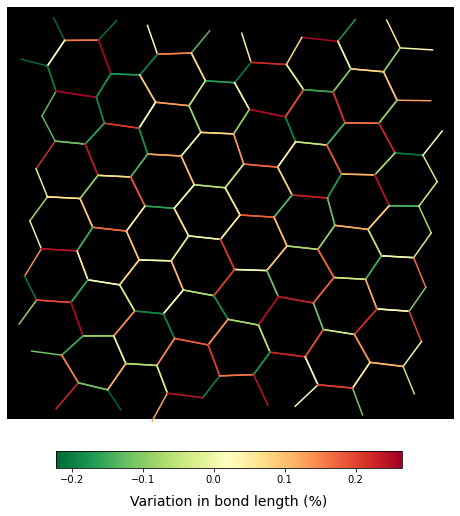

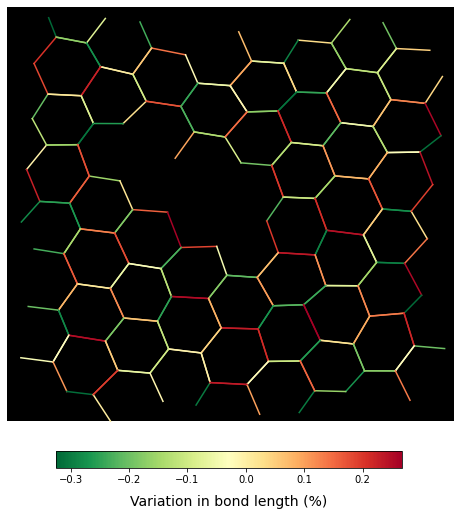

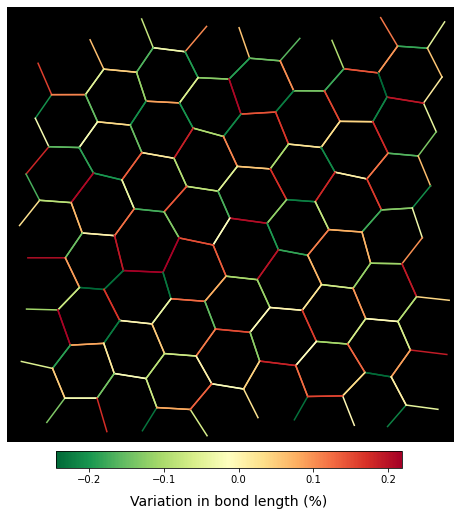

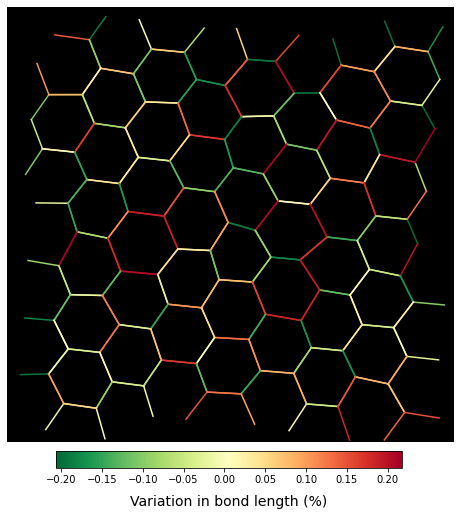

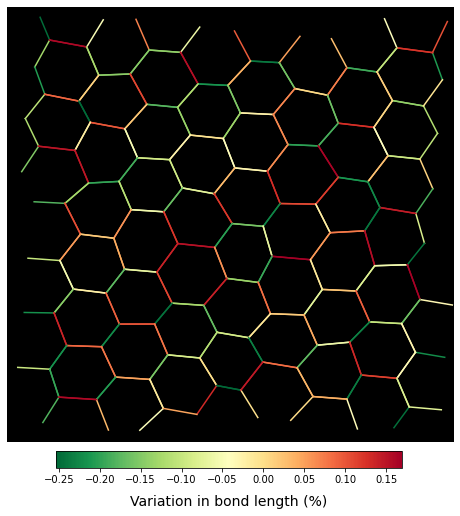

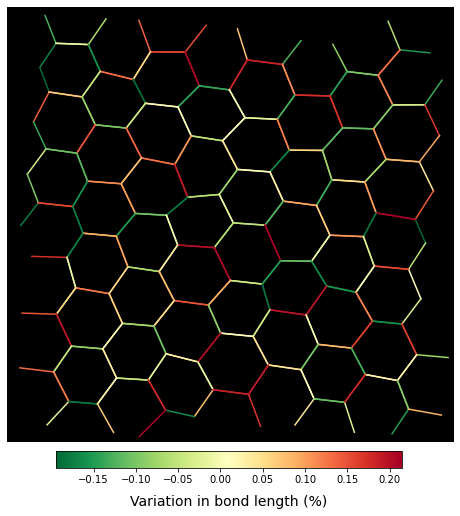

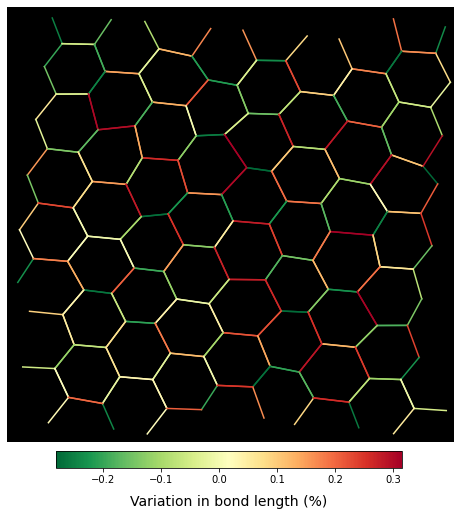

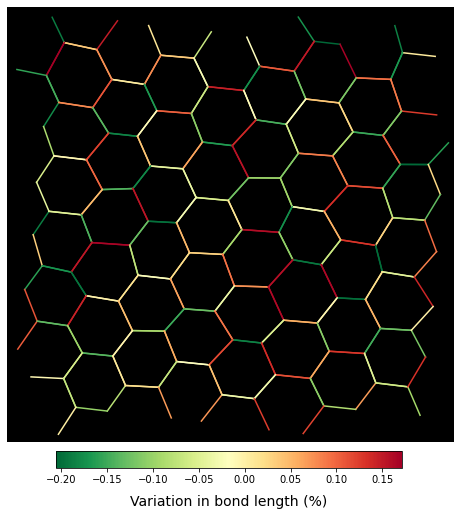

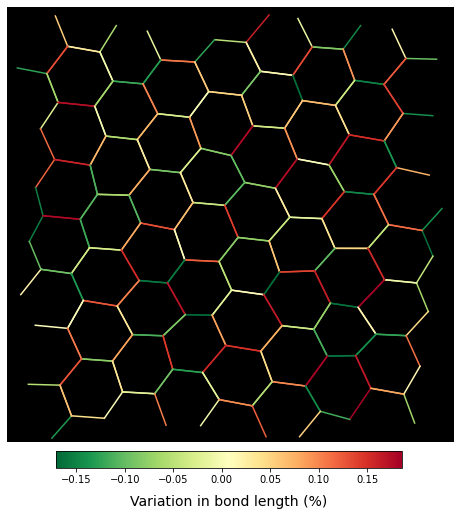

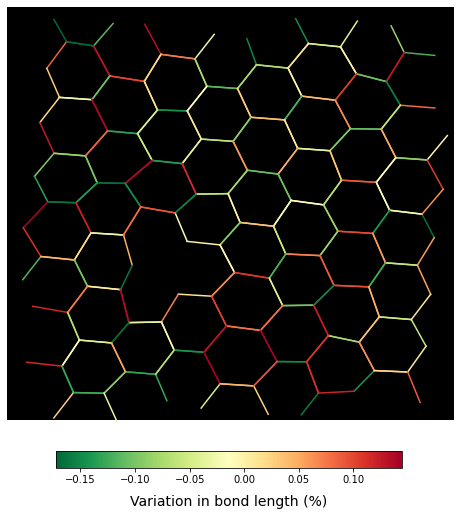

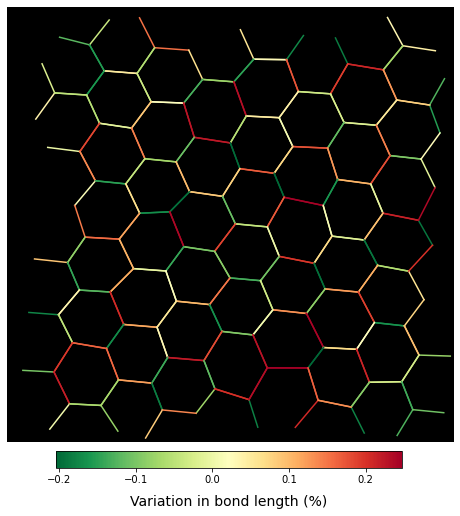

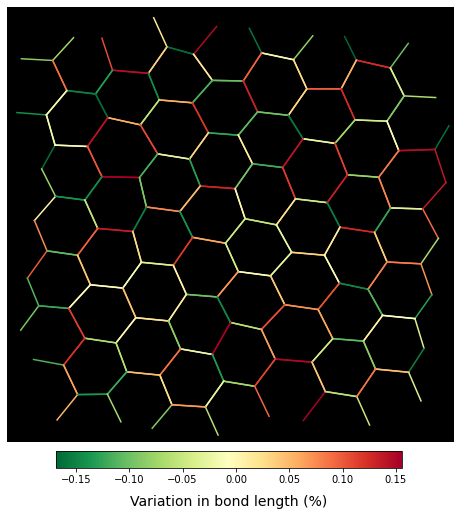

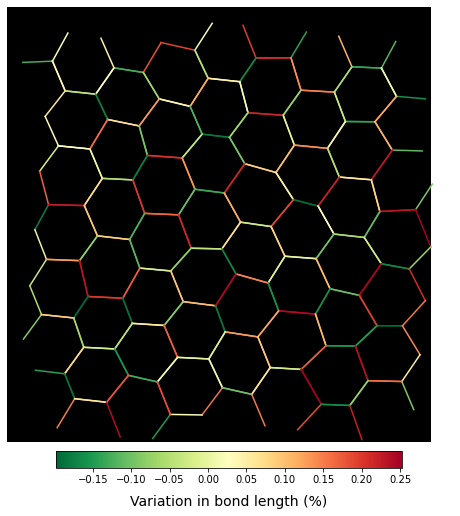

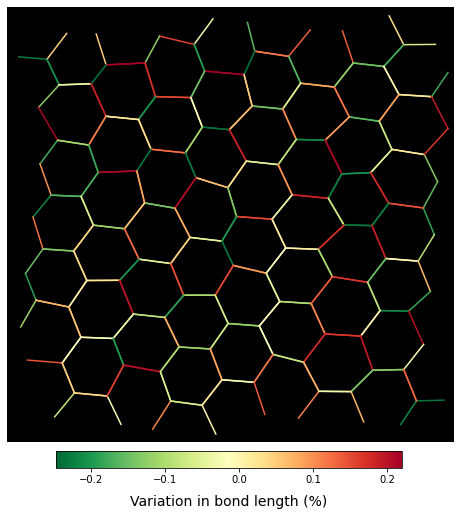

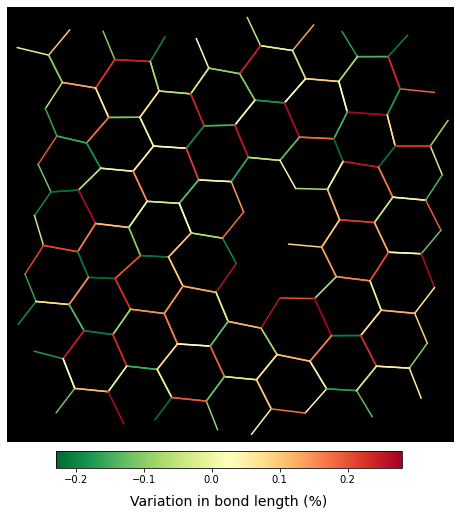

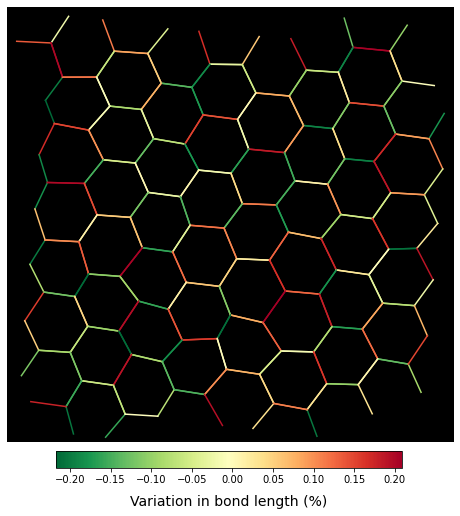

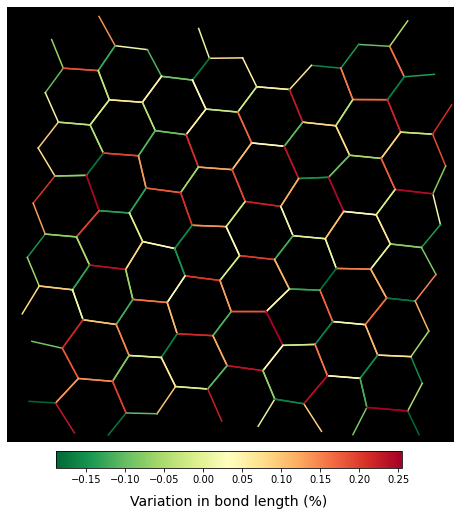

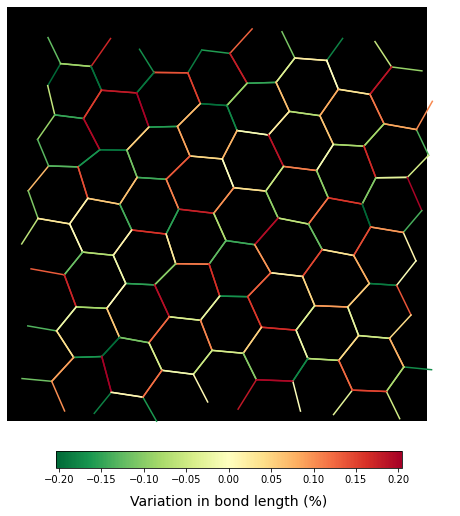

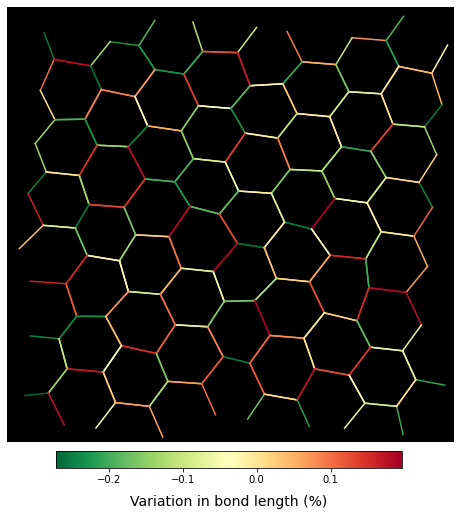

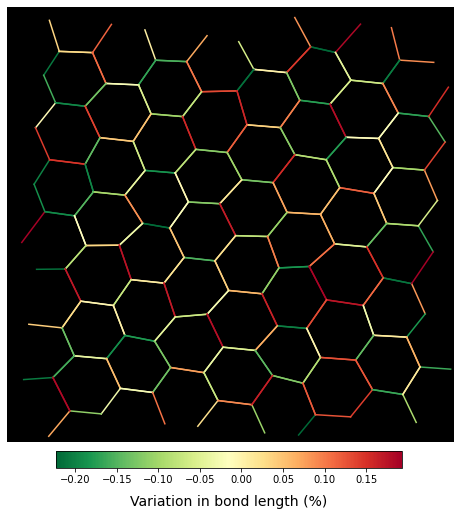

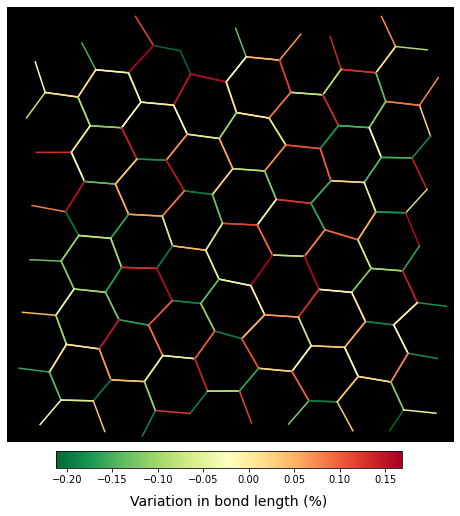

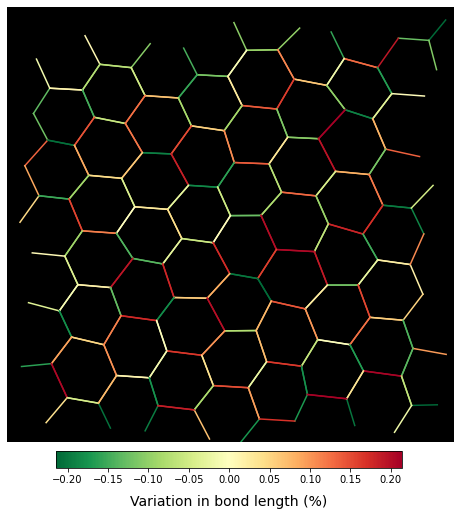

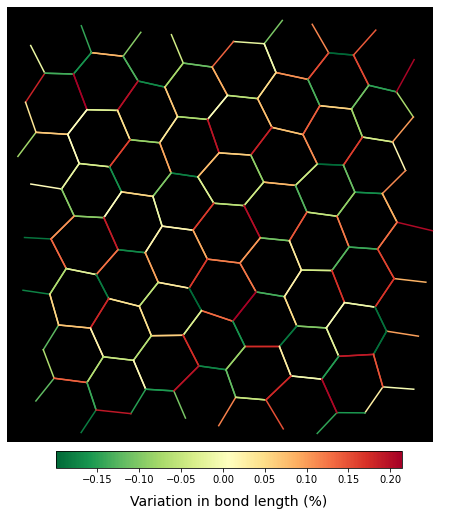

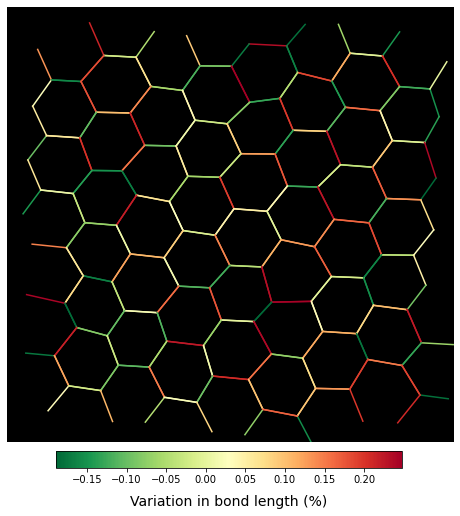

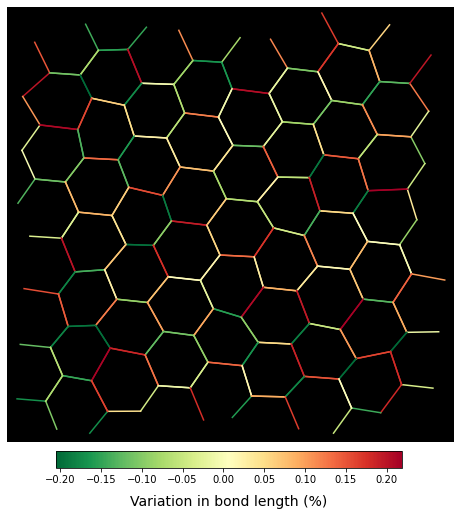

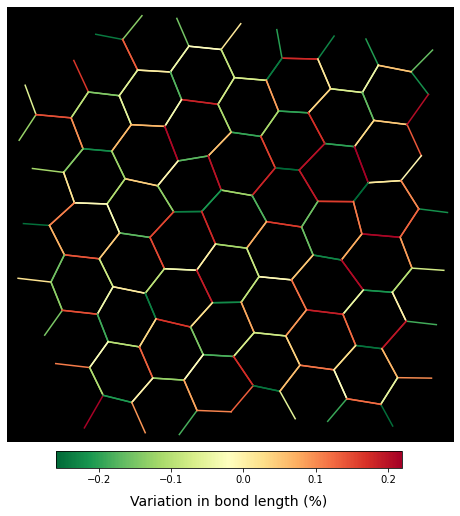

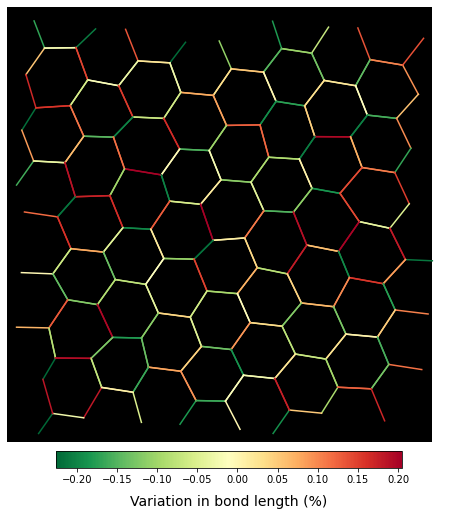

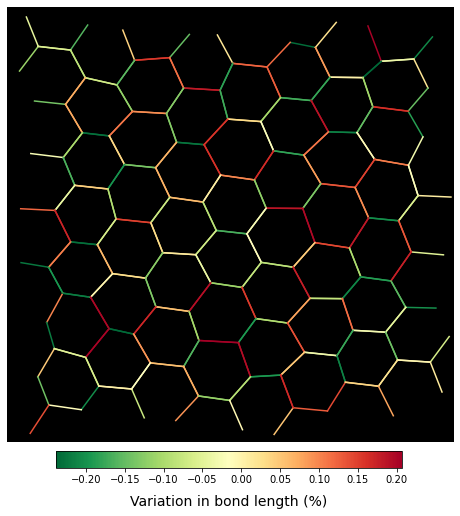

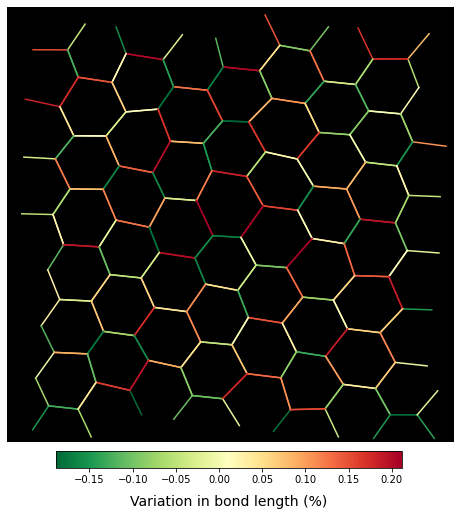

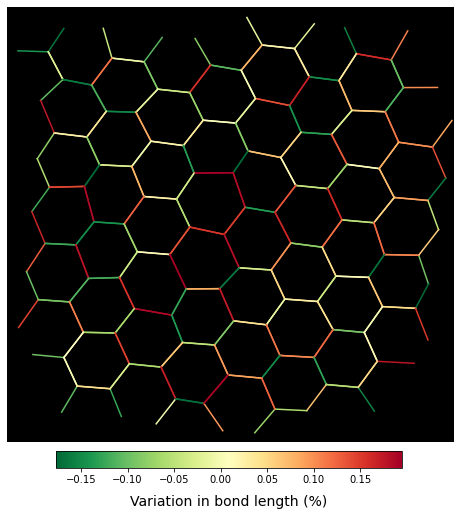

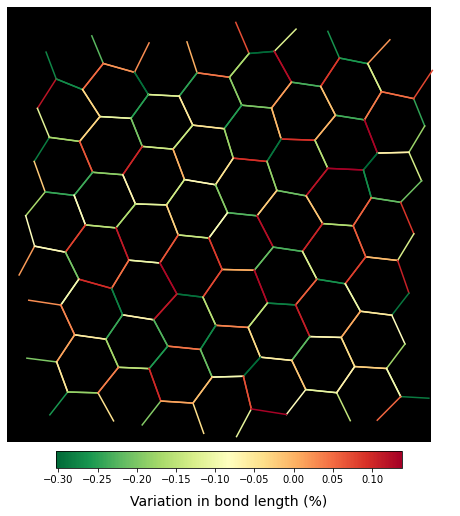

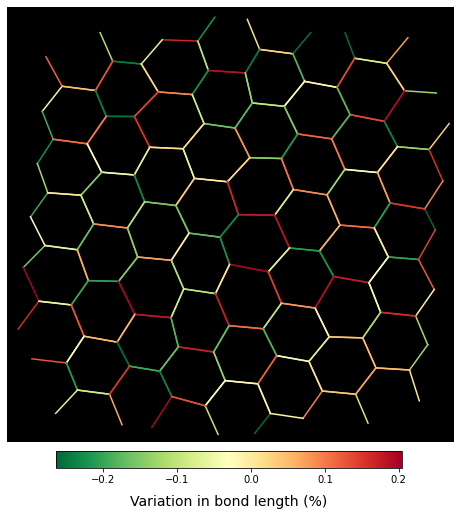

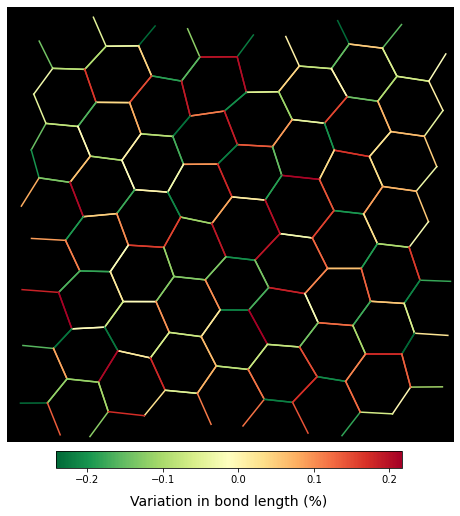

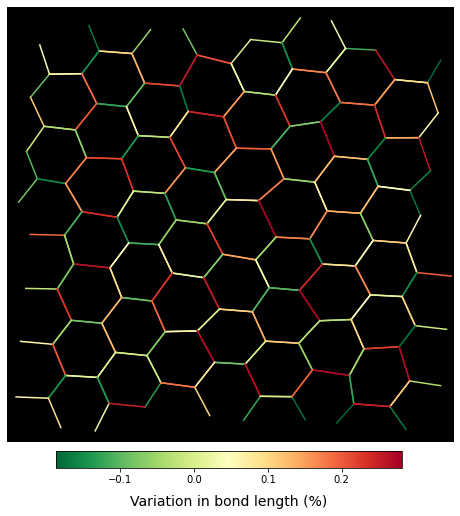

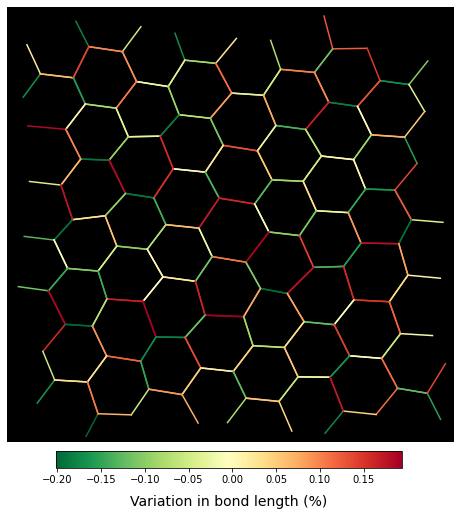

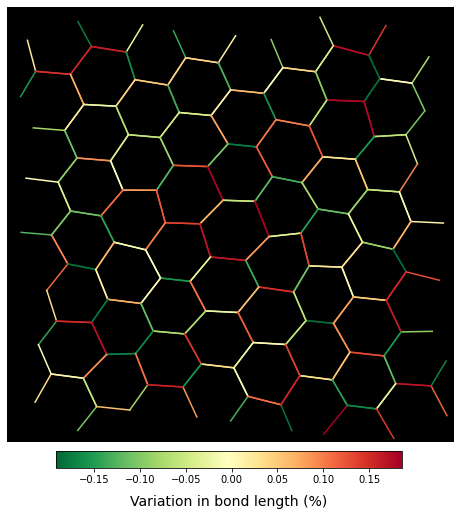

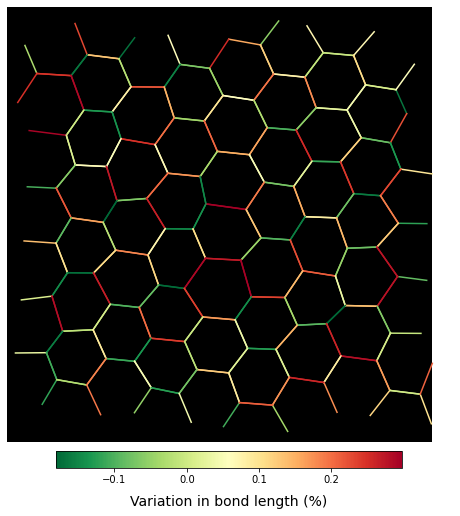

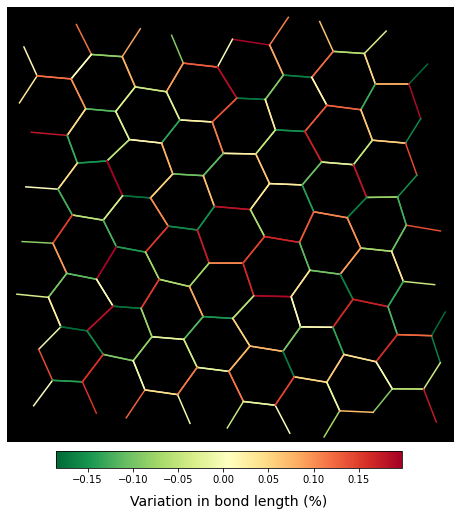

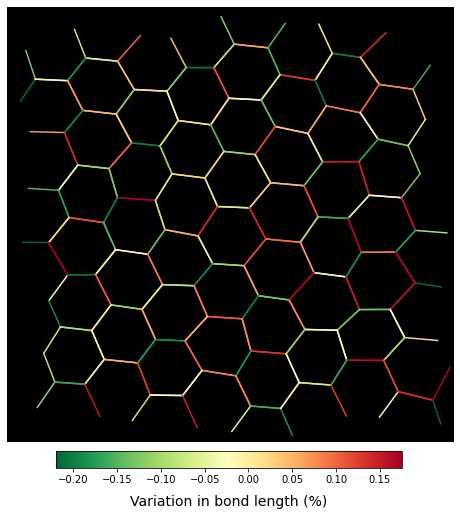

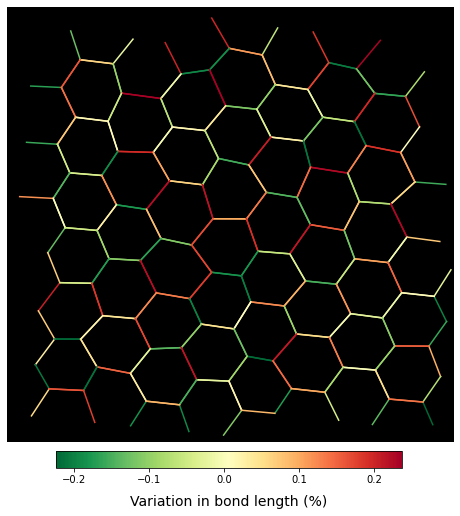

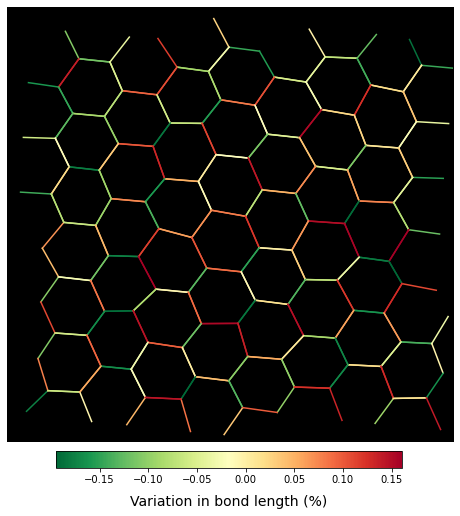

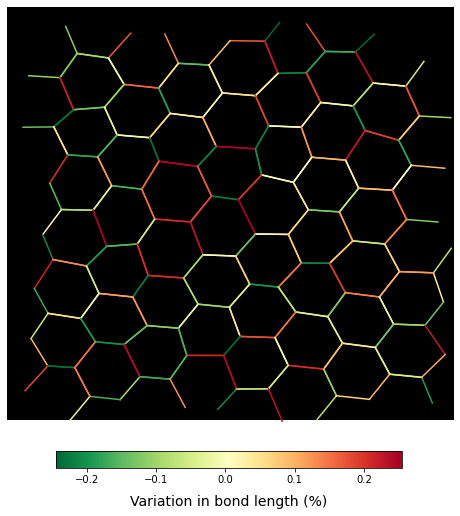

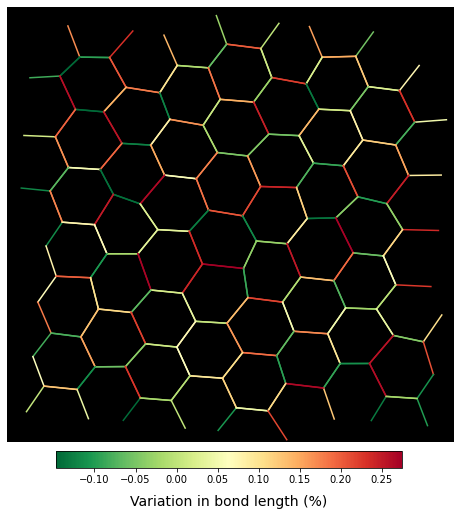

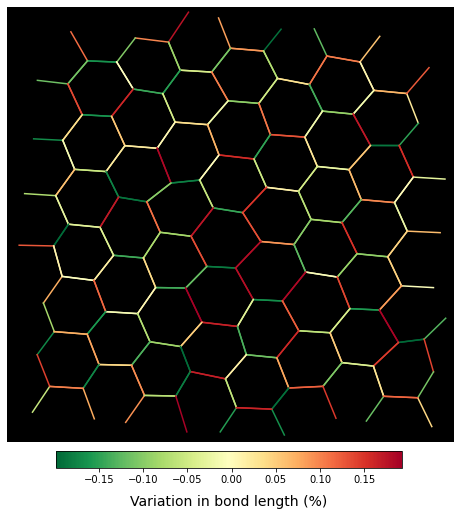

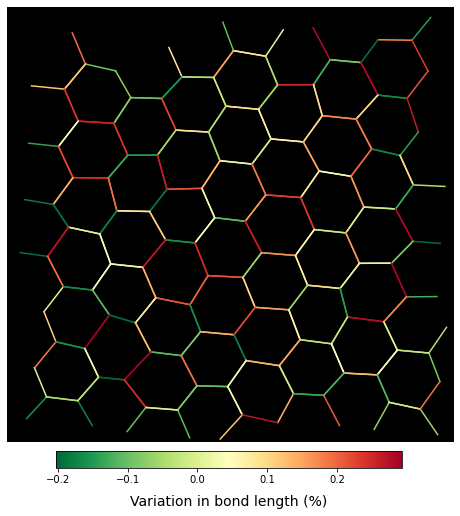

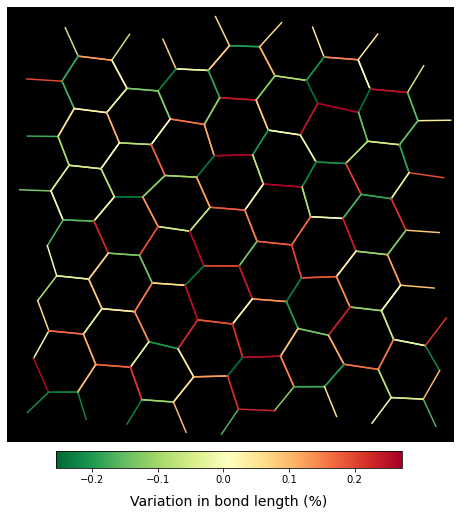

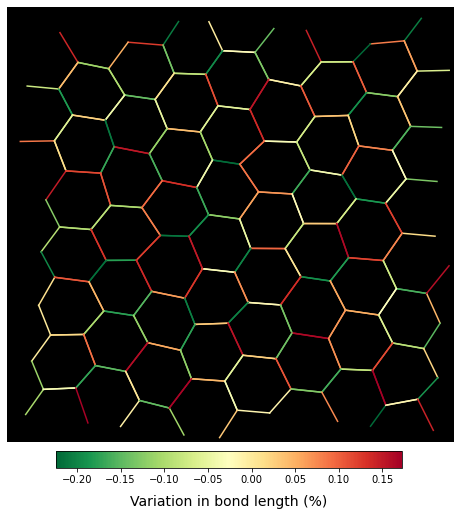

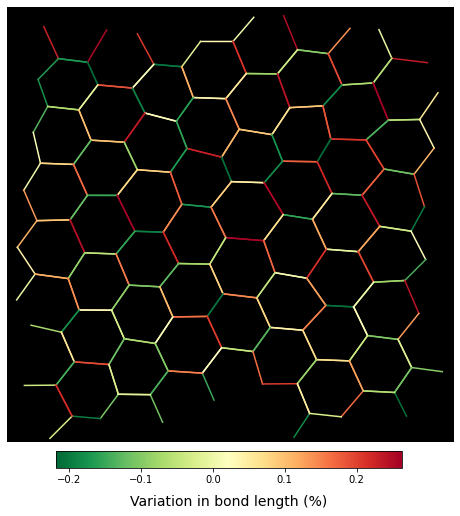

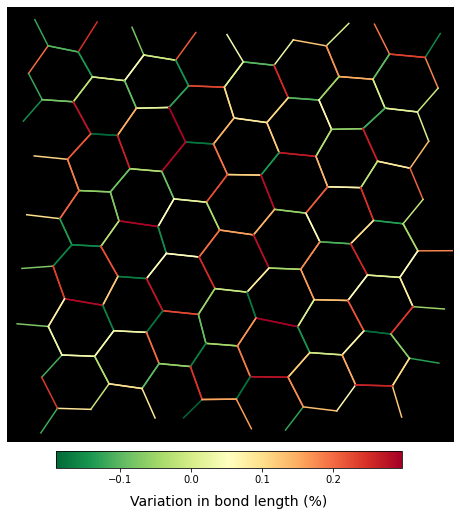

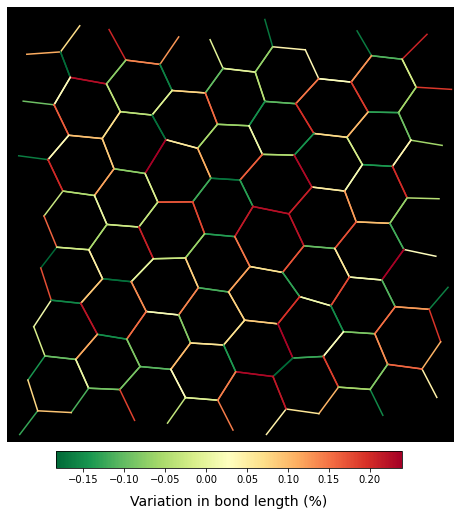

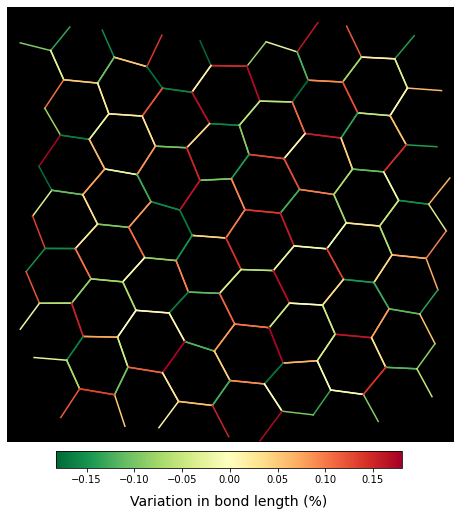

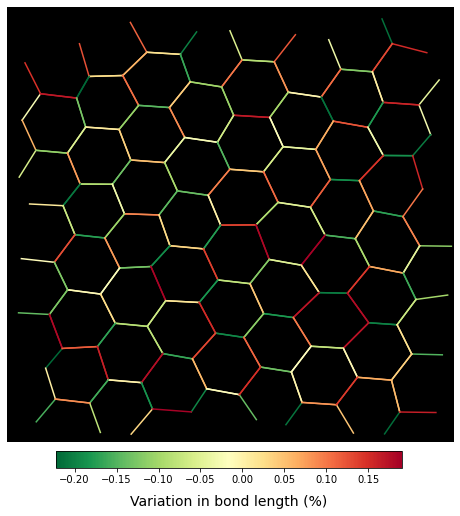

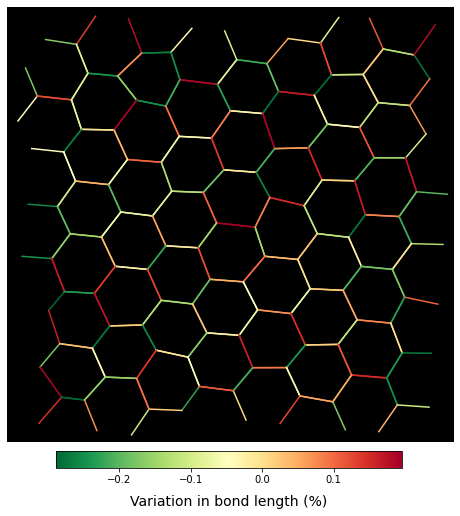

In [11]:
 distances_all = aoi.atomstat.map_bonds(coordinates, nn=3, upper_bound=25, plot_results=True)

We can also display the distances distribution converted from pixels to picometers:

Mean atomic distance (pm): 144.66902270238407
Standard deviation in distances (pm): 10.414869498943046


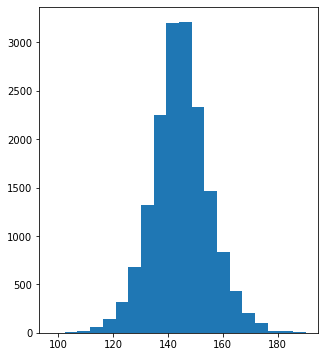

In [12]:
# pixel-to-picometre conversion coefficient (scan size = 2nm, h = w = 256 px)
px2pm = 7.81 
# Plot
plt.figure(figsize=(5, 6))
plt.hist(distances_all.flatten()*px2pm, bins=20);
distance_aver = np.mean(distances_all)
distance_sd = np.std(distances_all)
print("Mean atomic distance (pm):", distance_aver*px2pm)
print("Standard deviation in distances (pm):", distance_sd*px2pm)

Because we are going to construct local descriptors (stack of subimages) from the neural network output, we need to have the coordinates that correspond to the exaxt location of blobs in the output:

Batch 10/10
53 images were decoded in approximately 1.2727 seconds


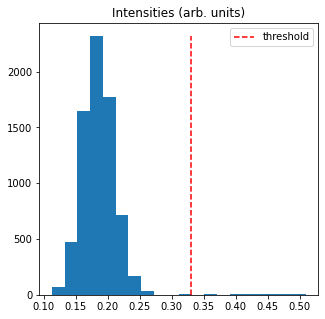

In [14]:
nn_input, (nn_output, coordinates) = aoi.atomnet.predictor(
    model, refine=False, logits=False, use_gpu=True).run(expdata)
coordinates = aoi.atomstat.update_classes(
    coordinates, nn_input, method='threshold', thresh=.33)

Here we create a set of descriptors (local sub-images) to analyze bulk distortions and distortions assocaited with movement of Si atom:

In [15]:
# size of subimages
wind_size = 2*int(1.73*(distance_aver + 3*distance_sd))
# initiate analysis of local descriptors for bulk C
imstack1 = aoi.atomstat.imlocal(nn_output, coordinates, wind_size, coord_class=0)
# initiate analysis of local descriptors for Si imputiry
imstack2 = aoi.atomstat.imlocal(nn_output, coordinates, wind_size, coord_class=1)

We are now going to run Gaussian mixture model to split subimages into two classes corresponding to two different sublattices in graphene and then perform PCA on each of the component (more specifically, on a stack of images labeled as class 1 and class 2 by GMM).

Notice how AtomAI allows us doing these operations with just one line of code. First we would like to vizualize PCA scree plots for each component.


GMM components


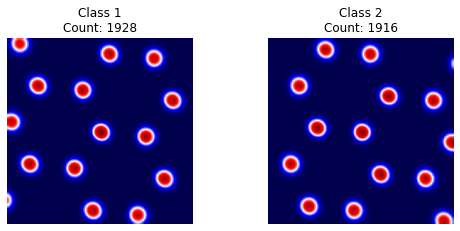


PCA scree plot for GMM component 1


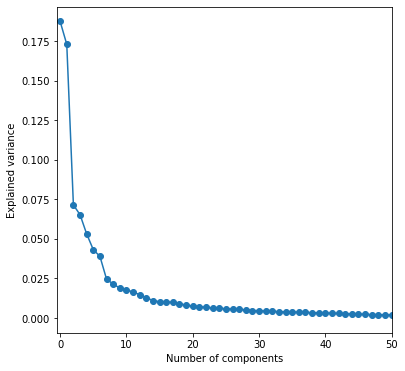


PCA scree plot for GMM component 2


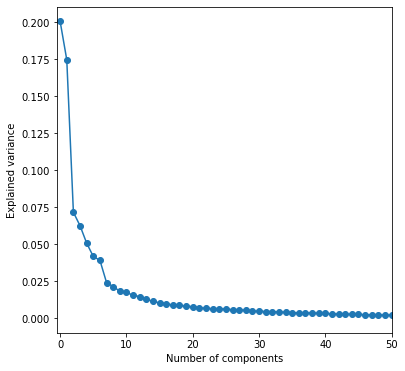


GMM components


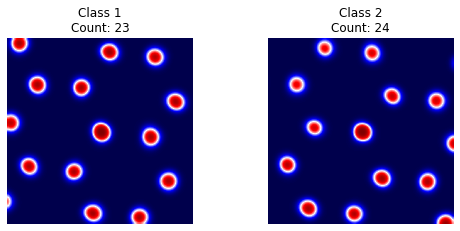


PCA scree plot for GMM component 1


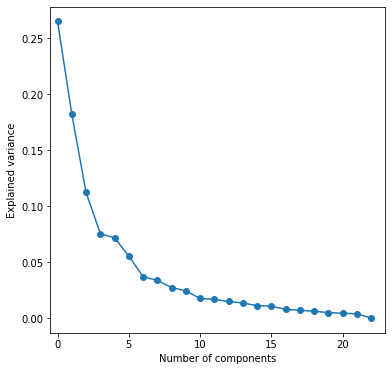


PCA scree plot for GMM component 2


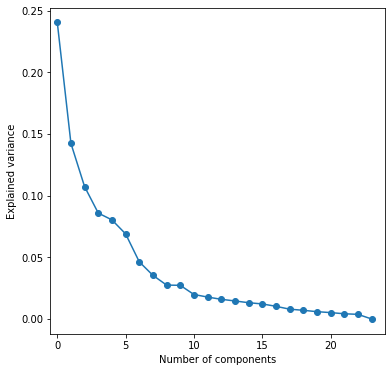

In [16]:
imstack1.pca_gmm_scree_plot(n_components_gmm=2);
imstack2.pca_gmm_scree_plot(n_components_gmm=2);

Now do PCA decomposition for two different graphene sublatice:

(notice that it is also possible to choose different number of PCA components for each GMM components; in this case, you just need to pass a list of integers instead of a single integer)


GMM components


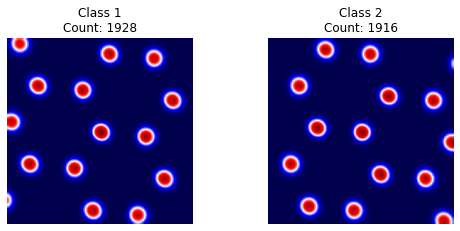


PCA components for GMM class 1


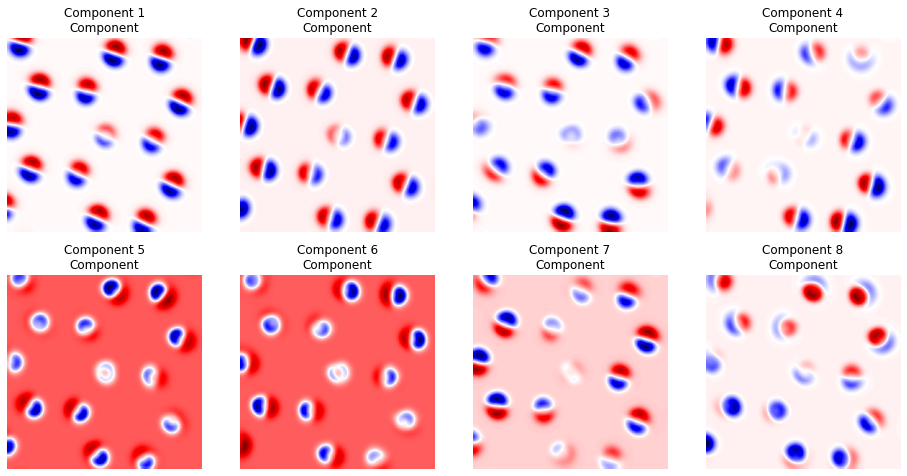


PCA components for GMM class 2


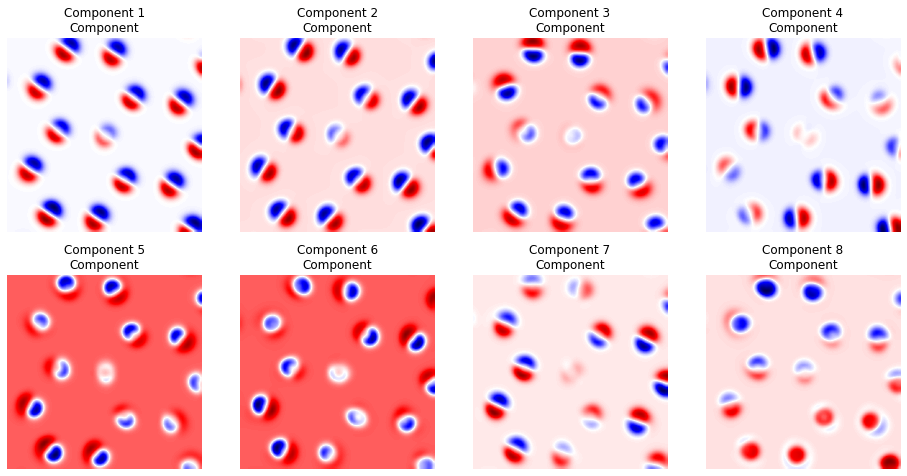


GMM components


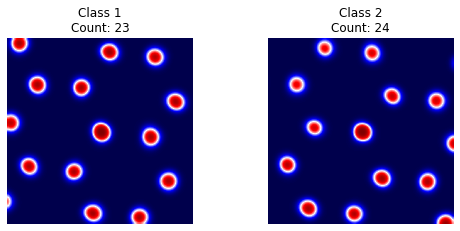


PCA components for GMM class 1


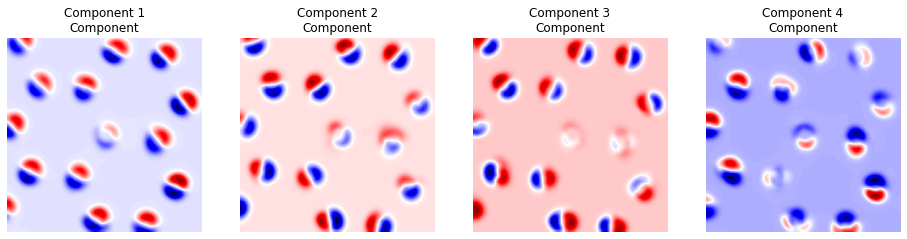


PCA components for GMM class 2


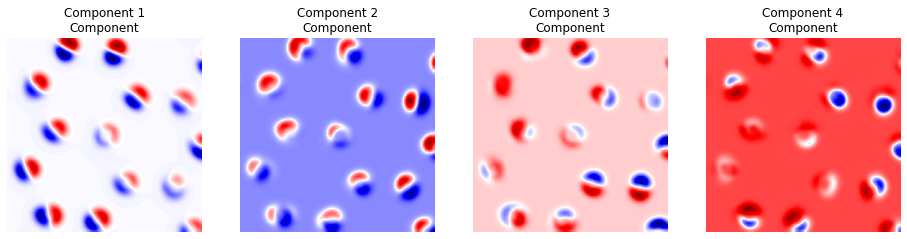

In [17]:
gmm_comp1, pca_comp1, Xt1, _ = imstack1.pca_gmm(
    n_components_gmm=2, n_components_pca=8, plot_results=True);
gmm_comp2, pca_comp2, Xt2, _ = imstack2.pca_gmm(
    n_components_gmm=2, n_components_pca=4, plot_results=True);

Plot the evolution of PCA components for impurity:

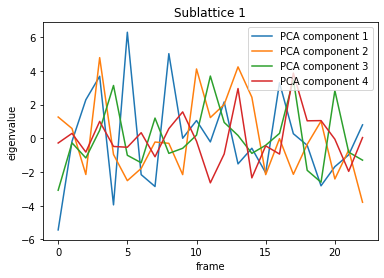

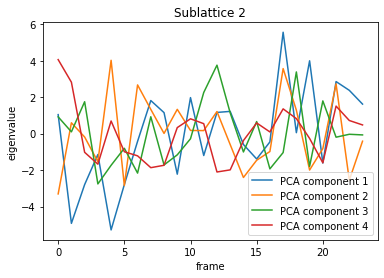

In [18]:
for j, subl in enumerate(Xt2):
    for i in range(subl.shape[-1]):
        plt.plot(subl[:, i], label='PCA component {}'.format(i+1))
    plt.legend()
    plt.title('Sublattice {}'.format(j+1))
    plt.xlabel('frame')
    plt.ylabel('eigenvalue')
    plt.show()